In [1]:
# To manipulate arrays
import pandas as pd
import pathlib
import sys
import numpy as np
from pathlib import Path
import tifffile
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import trackpy as tp

# Plotting
current_dir = pathlib.Path().absolute()
rsnaped_dir = current_dir.parents[0].joinpath('rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [2]:
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.detection as detection
import bigfish.multistack as multistack

In [3]:
video_dir = current_dir.parents[0].joinpath('/home/luisub/Desktop/rsnaped/DataBases/qbio_2022_translation/cell2')
path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
print(list_videos[0].shape) # (z,time, x, y)   # [Z, T, Y, X, C] 
selected_video = list_videos[0]

(10, 28, 512, 512)


In [4]:
selected_video.shape

(10, 28, 512, 512)

image shape: (10, 28, 512, 512)


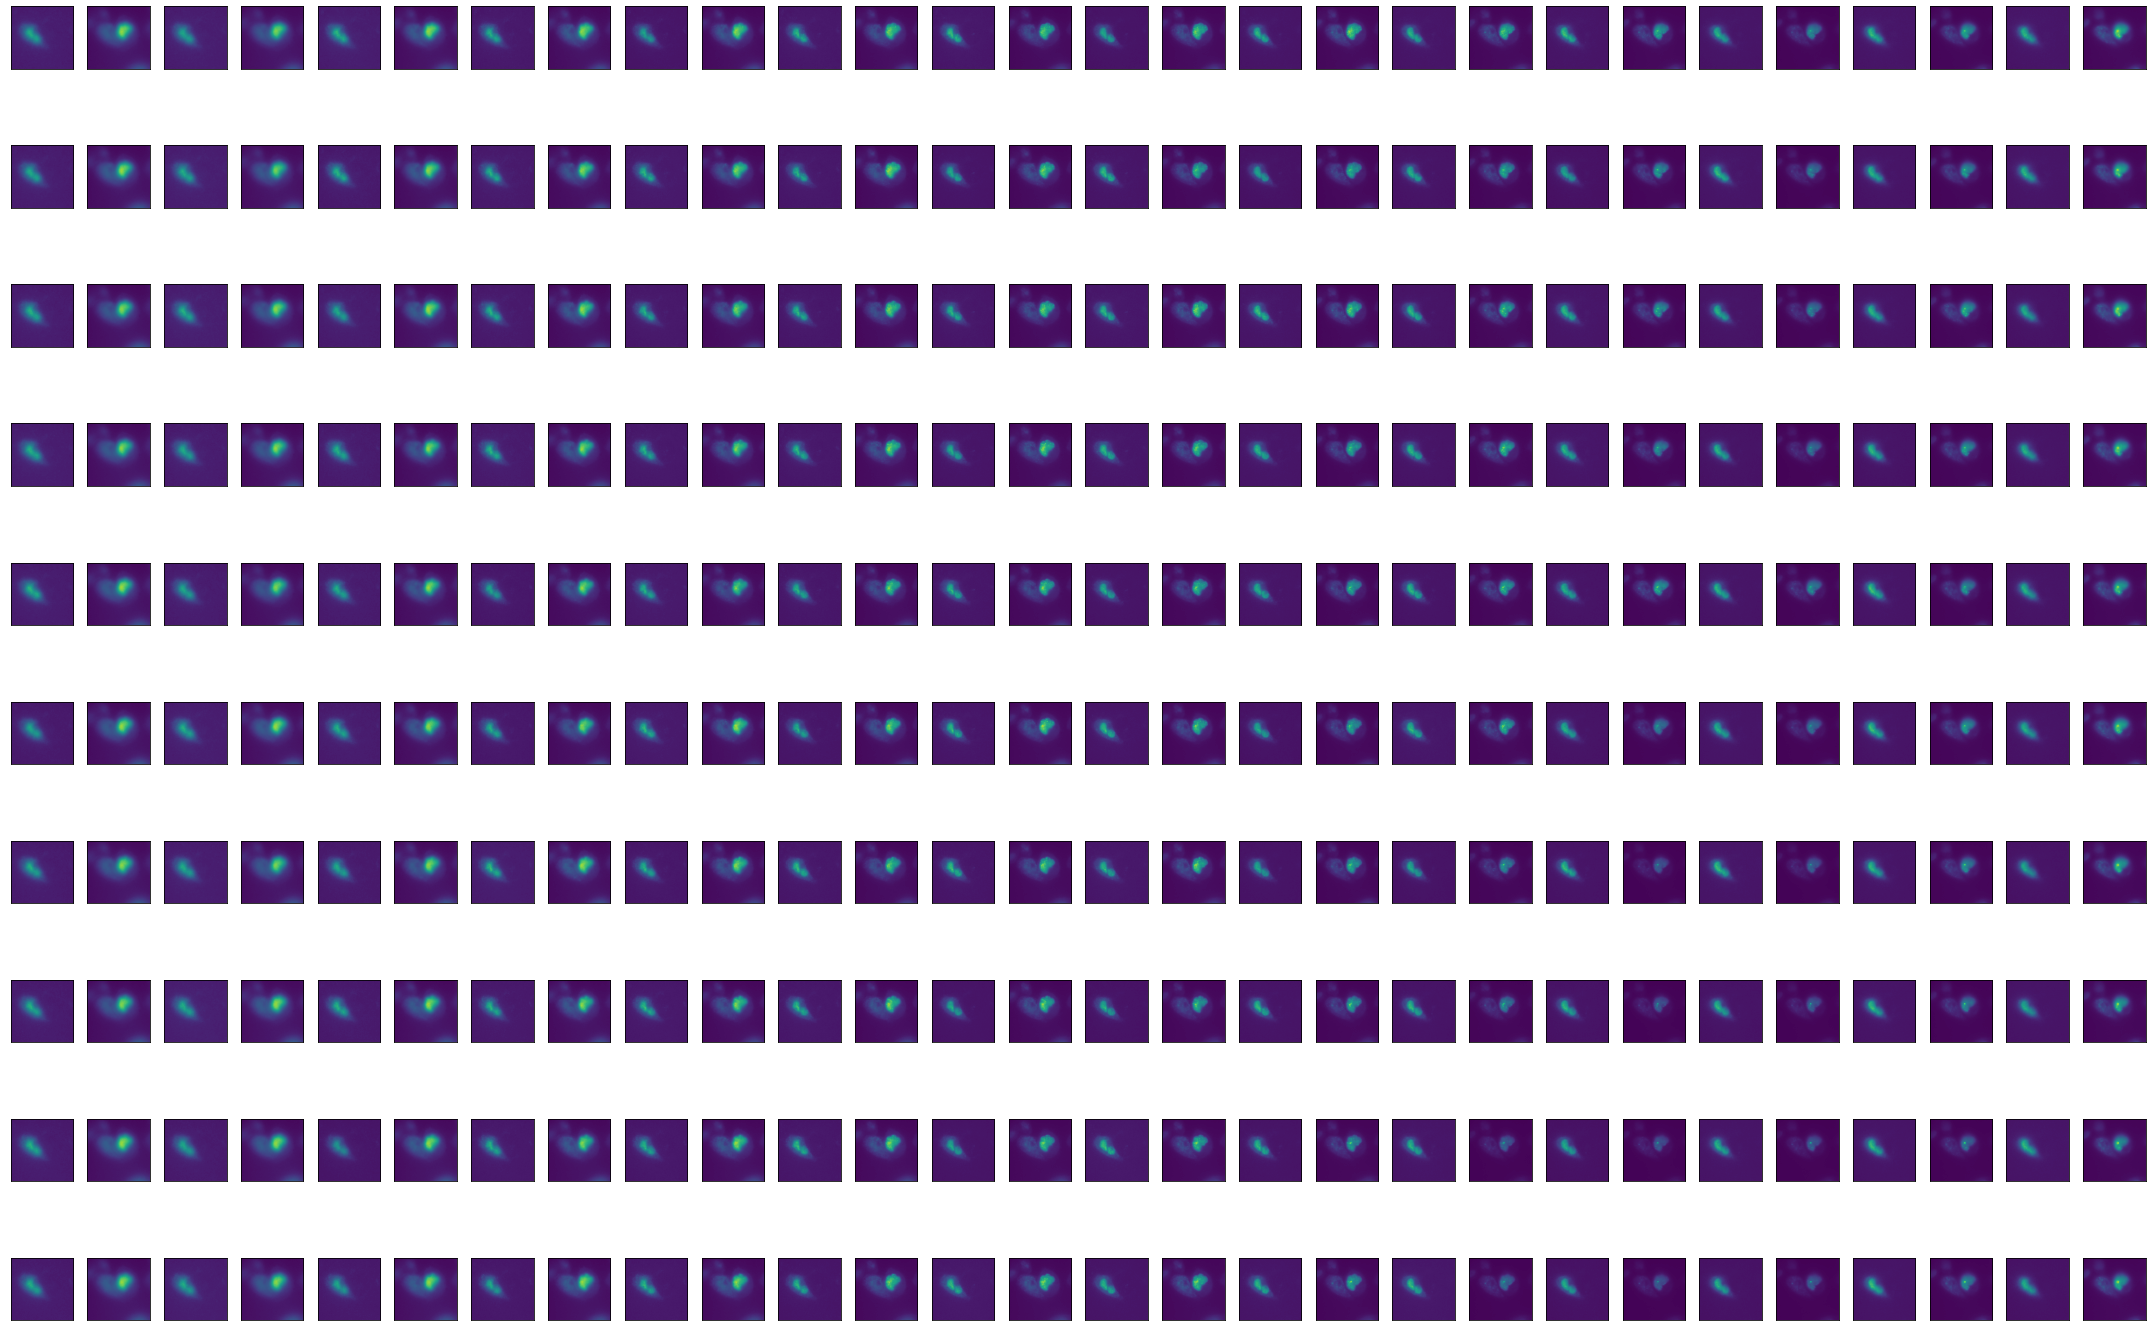

In [5]:
print('image shape:',selected_video.shape )
# Rows = Z, Columns = Time
num_z = selected_video.shape[0]
num_frames = selected_video.shape[1]
_, axes = plt.subplots(nrows = num_z, ncols = num_frames , figsize = (30, 20))

for j in range (num_z):
    for i in range (num_frames):
        axes[j,i].imshow(selected_video[j,i,:,:])
        axes[j,i].grid(False); axes[j,i].set_xticks([]); axes[j,i].set_yticks([])
plt.tight_layout()    
plt.show()
                                                                              

In [6]:
# Split the second dimension into odd and even indices
even_indices = selected_video[:, ::2, :, :]
odd_indices = selected_video[:, 1::2, :, :]
# Stack them along a new dimension
new_arr = np.stack((even_indices, odd_indices), axis=-1)
print(new_arr.shape)  # Outputs: (T, Z, Y, X, C)

(10, 14, 512, 512, 2)


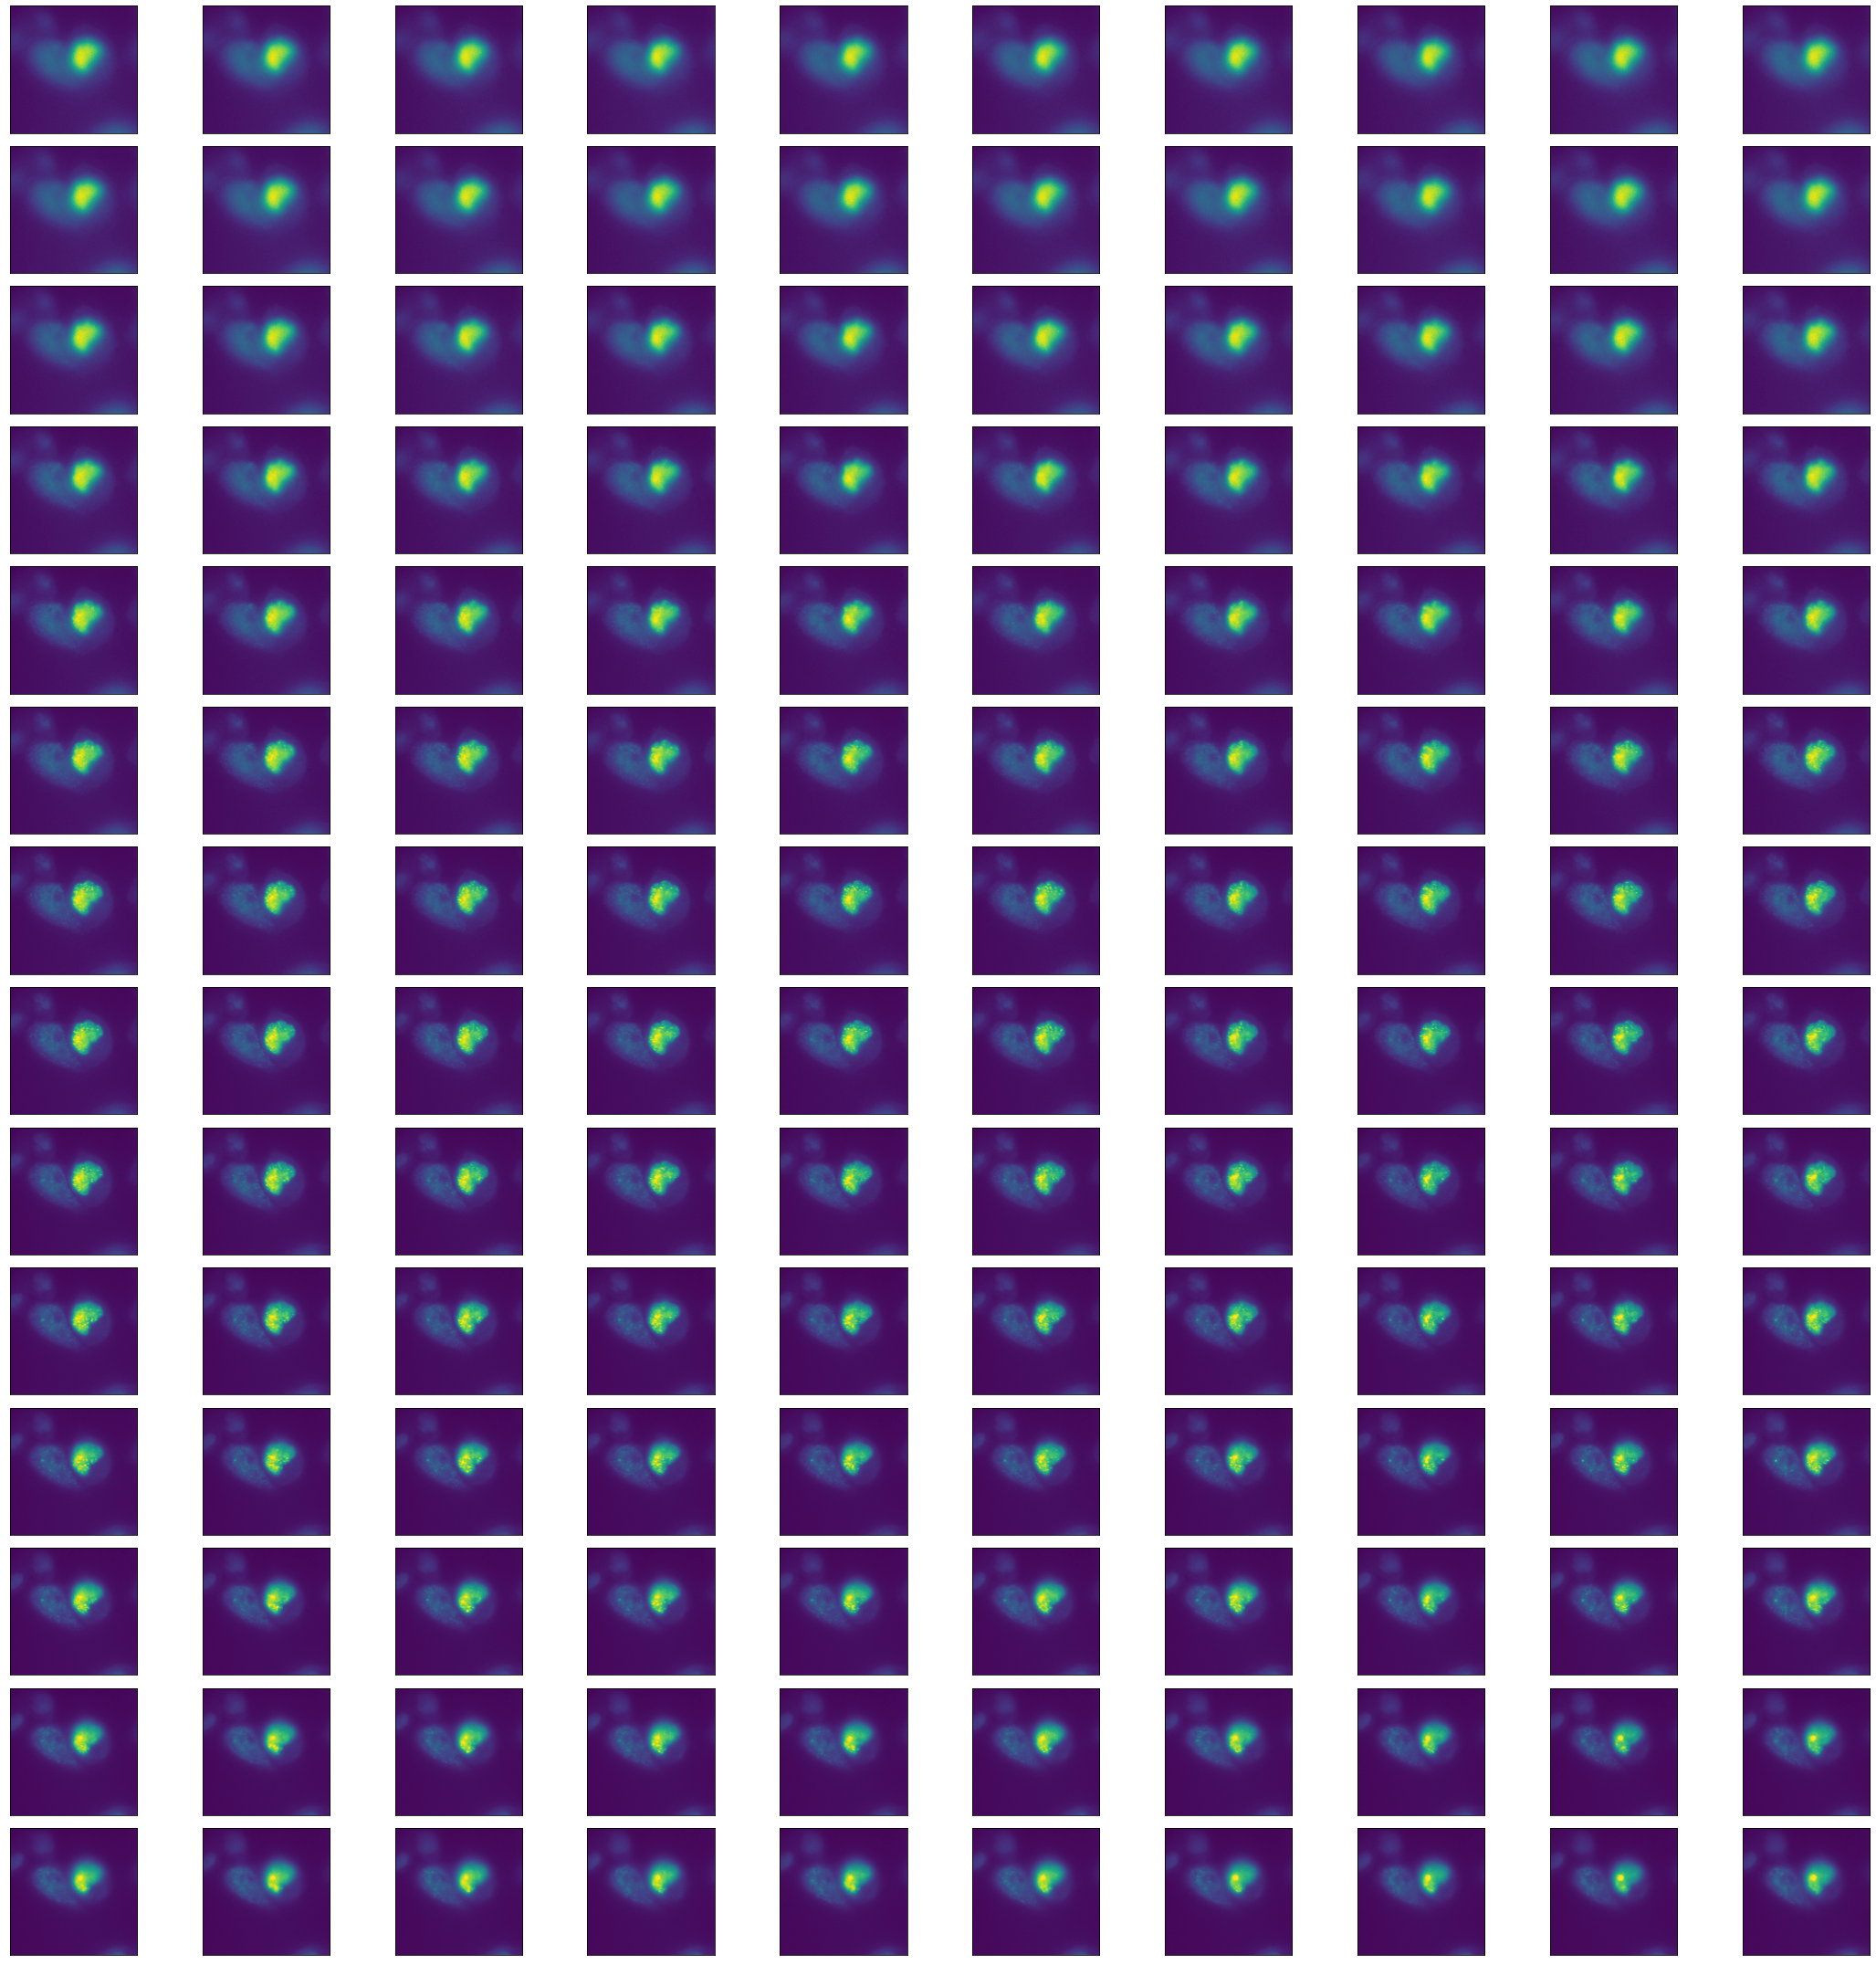

In [7]:
num_z = new_arr.shape[1]
num_frames = new_arr.shape[0]
selected_color_channel = 1

# Plotting
_, axes = plt.subplots(nrows = num_z, ncols = num_frames , figsize = (30, 30))
for j in range (num_z):
    for i in range (num_frames):
        temp_img = rsp.RemoveExtrema(new_arr[i,j,:,:,selected_color_channel], min_percentile = 0.1, max_percentile = 99.9,format_video='YX').remove_outliers()
        axes[j,i].imshow(temp_img)
        axes[j,i].grid(False); axes[j,i].set_xticks([]); axes[j,i].set_yticks([])
plt.tight_layout()    
plt.show()

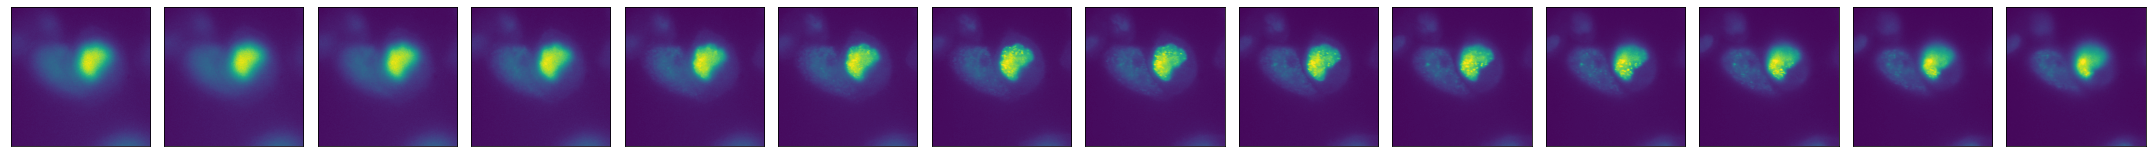

In [8]:
# Using big-fish to detect the spots in single time point.

selected_time =0
new_arr_time_point = new_arr[selected_time,:,:,:,:]
num_z = new_arr_time_point.shape[0]
selected_color_channel = 1

# Plotting
_, axes = plt.subplots(nrows = 1, ncols = num_z , figsize = (30, 30))
for i in range (num_z):
    temp_img = rsp.RemoveExtrema(new_arr_time_point[i,:,:,selected_color_channel], min_percentile = 0.01, max_percentile = 99.99,format_video='YX').remove_outliers()
    axes[i].imshow(temp_img)
    axes[i].grid(False); axes[i].set_xticks([]); axes[i].set_yticks([])
plt.tight_layout()    
plt.show()

In [9]:
def spot_detection_3d (rna,threshold_for_spot_detection=None,psf_z=350 ,psf_yx=140,voxel_size_z=500,voxel_size_yx=120,cluster_radius=400,minimum_spots_cluster=3):

    # Calculating Sigma with  the parameters for the PSF.
    spot_radius_px = detection.get_object_radius_pixel(voxel_size_nm=(voxel_size_z,voxel_size_yx, voxel_size_yx), 
                                                    object_radius_nm=(psf_z, psf_yx, psf_yx), ndim=3)
    sigma = spot_radius_px
    ## SPOT DETECTION
    try:
        rna_filtered = stack.log_filter(rna, sigma) # LoG filter
    except ValueError:
        print('Error during the log filter calculation, try using larger parameters values for the psf')
        rna_filtered = stack.remove_background_gaussian(rna, sigma)
    mask = detection.local_maximum_detection(rna_filtered, min_distance=sigma) # local maximum detection        
    
    if not (threshold_for_spot_detection is None):
        threshold = threshold_for_spot_detection
    else:
        threshold = detection.automated_threshold_setting(rna_filtered, mask) # thresholding

    spots, _ = detection.spots_thresholding(rna_filtered, mask, threshold, remove_duplicate=True)
    spots_post_decomposition, _, _ = detection.decompose_dense(image=rna, 
                                                            spots=spots, 
                                                            voxel_size = (voxel_size_z, voxel_size_yx, voxel_size_yx), 
                                                            spot_radius = (psf_z, psf_yx, psf_yx),
                                                            alpha=0.9,   # alpha impacts the number of spots per candidate region
                                                            beta=1,      # beta impacts the number of candidate regions to decompose
                                                            gamma=5)     # gamma the filtering step to denoise the image

    spots_post_clustering, clusters = detection.detect_clusters(spots_post_decomposition, 
                                                voxel_size=(voxel_size_z, voxel_size_yx, voxel_size_yx),
                                                radius= cluster_radius,
                                                nb_min_spots = minimum_spots_cluster)

    # remove spots that are part of a cluster
    spots_post_clustering = spots_post_clustering[spots_post_clustering[:,-1]==-1 ]
    
    return spots_post_clustering[:, :3], clusters ,rna_filtered

clusters:  0 , spots:  62


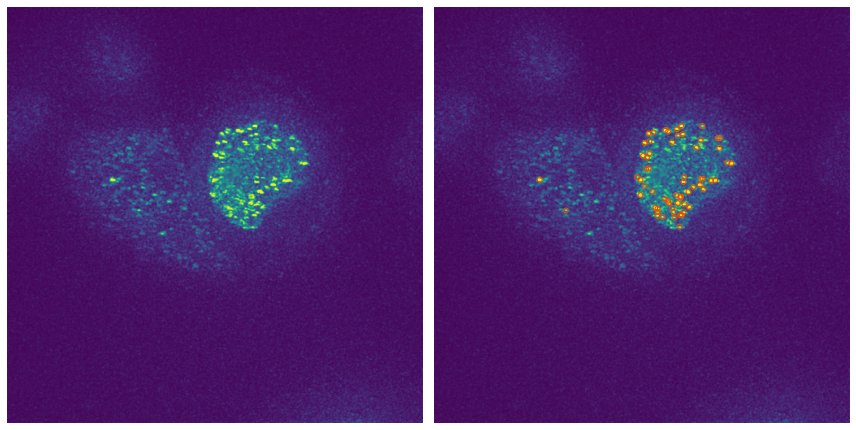

In [45]:
selected_time =0
new_arr_time_point = new_arr[selected_time,:,:,:,:]
rna=new_arr_time_point[:,:,:,selected_color_channel]
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=2500)

print('clusters: ',clusters.shape[0],   ', spots: ',spots.shape[0] )

plot.plot_detection(np.max(rna_filtered,axis=0), 
                spots=[spots[:, :3], clusters[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[3, 6], 
                color=["orangered", "blue"],
                linewidth=[1, 1], 
                fill=[False, False], 
                framesize=(12, 7), 
                contrast=True,
                rescale=True,)

clusters:  0 , spots:  59


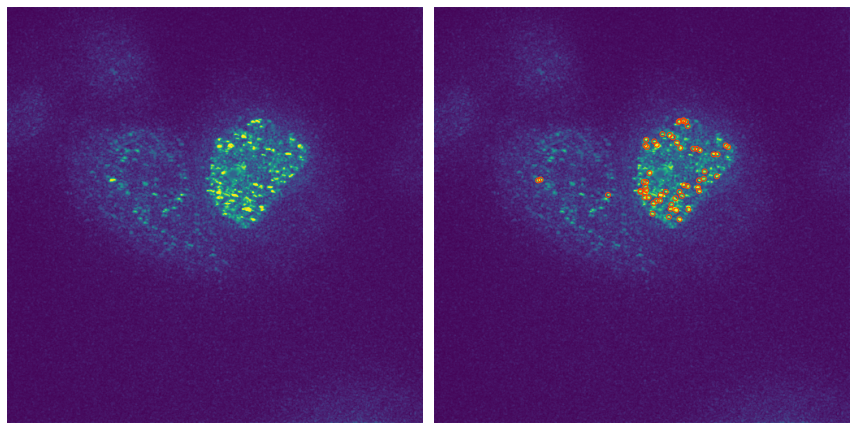

In [47]:
selected_time =4
new_arr_time_point = new_arr[selected_time,:,:,:,:]
rna=new_arr_time_point[:,:,:,selected_color_channel]
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=2500)

print('clusters: ',clusters.shape[0],   ', spots: ',spots.shape[0] )

plot.plot_detection(np.max(rna_filtered,axis=0), 
                spots=[spots[:, :3], clusters[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[3, 6], 
                color=["orangered", "blue"],
                linewidth=[1, 1], 
                fill=[False, False], 
                framesize=(12, 7), 
                contrast=True,
                rescale=True,)

clusters:  0 , spots:  70


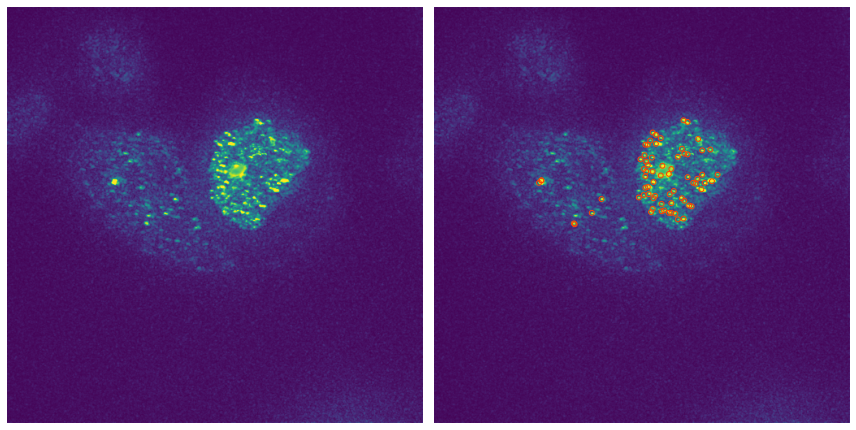

In [46]:
selected_time =9
new_arr_time_point = new_arr[selected_time,:,:,:,:]
rna=new_arr_time_point[:,:,:,selected_color_channel]
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=2500)

print('clusters: ',clusters.shape[0],   ', spots: ',spots.shape[0] )

plot.plot_detection(np.max(rna_filtered,axis=0), 
                spots=[spots[:, :3], clusters[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[3, 6], 
                color=["orangered", "blue"],
                linewidth=[1, 1], 
                fill=[False, False], 
                framesize=(12, 7), 
                contrast=True,
                rescale=True,)

In [49]:
def spots_3d_spots_plot (image,spots,clusters):
    # Sample coordinates
    y_spots = spots[:, 2]  # 
    x_spots = spots[:, 1]  # 
    z_spots = spots[:, 0]  # 
    x_clusters = clusters[:, 1]
    y_clusters = clusters[:, 2]
    z_clusters = clusters[:, 0]
    # Create a 3D plot and a 2D image plot
    fig = plt.figure(figsize=(14, 6))
    # Create the 3D subplot directly
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(x_spots, y_spots, z_spots, c='r', marker='o')
    ax1.scatter(x_clusters, y_clusters, z_clusters, c='b', marker='o')
    ax1.set_xlabel('Y', fontsize=14)
    ax1.set_ylabel('X', fontsize=14)
    ax1.set_title('3D Spots', fontsize=16)
    ax1.view_init(elev=20, azim=-5)
    ax1.invert_zaxis()  # Invert z-axis
    ax1.set_xlim(0, rna.shape[2])
    ax1.set_ylim(0, rna.shape[1])
    ax1.grid(True)
    ax1.set_xticks([])
    # Plot the 2D image
    ax2 = plt.subplot(132)
    ax2.imshow(np.max(rna_filtered, axis=0), cmap='bone')
    ax2.set_title('max_log_filter + spots', fontsize=16)
    # Plot clusters as circles on top of the 2D image
    radii = clusters[:, 3]*2
    for x, y, r in zip( y_clusters,x_clusters, radii):
        circle = Circle((x, y), r, color='cyan', fill=False)
        ax2.add_patch(circle)
    # Plot circles on top of the 2D image
    radii = len(y_spots) * [3]
    for x, y, r in zip( y_spots,x_spots, radii):
        circle = Circle((x, y), r, color='red', fill=False)
        ax2.add_patch(circle)
    ax2.grid(True)
    # Plot the 2D image
    ax3 = plt.subplot(133)
    ax3.imshow(np.max(rna_filtered, axis=0), cmap='bone')
    ax3.set_title('max_log_filter', fontsize=16)
    ax3.grid(True)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()


[]


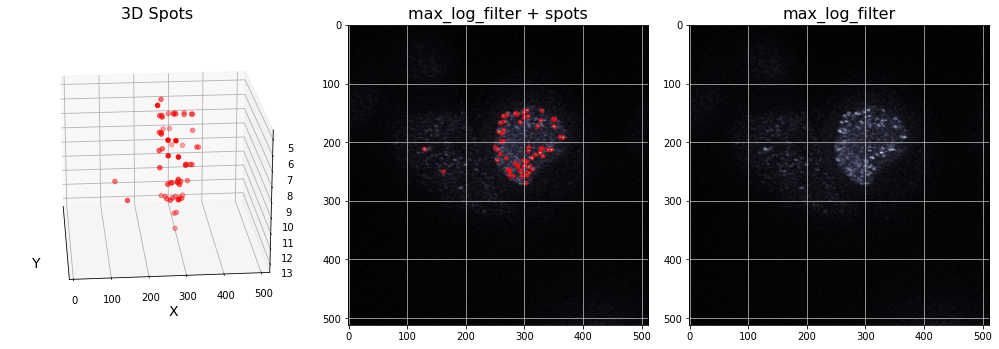

In [53]:
selected_time =0
new_arr_time_point = new_arr[selected_time,:,:,:,:]
rna=new_arr_time_point[:,:,:,selected_color_channel]
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=2500)
spots_3d_spots_plot (image=np.max(rna_filtered, axis=0),spots=spots,clusters=clusters)

[]


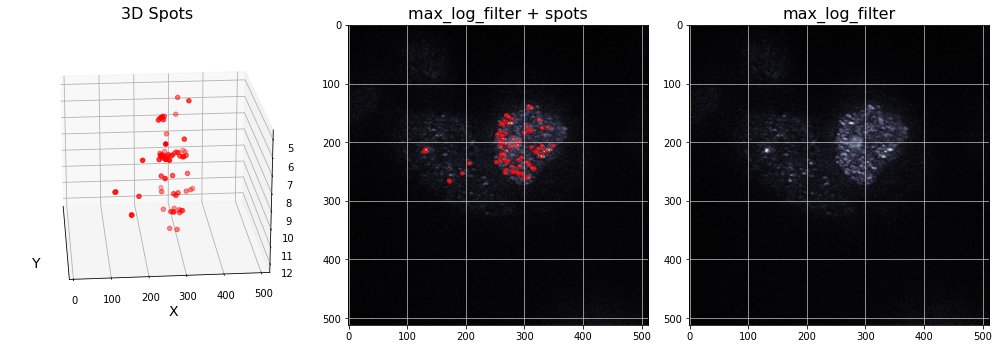

In [54]:
selected_time =9
new_arr_time_point = new_arr[selected_time,:,:,:,:]
rna=new_arr_time_point[:,:,:,selected_color_channel]
spots, clusters,rna_filtered = spot_detection_3d (rna,threshold_for_spot_detection=2500)
spots_3d_spots_plot (image=np.max(rna_filtered, axis=0),spots=spots,clusters=clusters)

In [55]:
new_arr.shape

(10, 14, 512, 512, 2)

In [71]:
# iterate for all frames
df = pd.DataFrame() #columns=['frame', 'x', 'y', 'z'])
selected_color_channel = 1
num_frames = new_arr.shape[0]

for i in range (num_frames):
    rna=new_arr[i,:,:,:,selected_color_channel]
    spots, clusters,_ = spot_detection_3d (rna,threshold_for_spot_detection=2500)
    print(spots.shape)
    if spots.shape[0] == 0:
        continue
    temp_array =np.zeros((spots.shape[0],4))
    temp_array[:,0]=i
    temp_array[:,1:]=spots
    array_df = pd.DataFrame(temp_array)
# Append values to the DataFrame
    df = pd.concat([df, array_df], ignore_index=True)


(62, 3)
(53, 3)
(59, 3)
(69, 3)
(59, 3)
(56, 3)
(55, 3)
(48, 3)
(55, 3)
(70, 3)


In [72]:
df

0     1      2      3
0    0.0   5.0  155.0  264.0
1    0.0   5.0  209.0  250.0
2    0.0   6.0  146.0  330.0
3    0.0   6.0  156.0  306.0
4    0.0   6.0  158.0  300.0
..   ...   ...    ...    ...
581  9.0  10.0  254.0  297.0
582  9.0  11.0  267.0  173.0
583  9.0  11.0  253.0  289.0
584  9.0  11.0  260.0  307.0
585  9.0  12.0  261.0  300.0

[586 rows x 4 columns]

In [73]:
df = df.rename(columns={0: 'frame', 1: 'z', 2: 'y', 3: 'x'})
df

frame     z      y      x
0      0.0   5.0  155.0  264.0
1      0.0   5.0  209.0  250.0
2      0.0   6.0  146.0  330.0
3      0.0   6.0  156.0  306.0
4      0.0   6.0  158.0  300.0
..     ...   ...    ...    ...
581    9.0  10.0  254.0  297.0
582    9.0  11.0  267.0  173.0
583    9.0  11.0  253.0  289.0
584    9.0  11.0  260.0  307.0
585    9.0  12.0  261.0  300.0

[586 rows x 4 columns]

In [74]:
f = df

In [75]:
f_2d = f[['frame', 'y', 'x']].copy()
print(f_2d)

     frame      y      x
0      0.0  155.0  264.0
1      0.0  209.0  250.0
2      0.0  146.0  330.0
3      0.0  156.0  306.0
4      0.0  158.0  300.0
..     ...    ...    ...
581    9.0  254.0  297.0
582    9.0  267.0  173.0
583    9.0  253.0  289.0
584    9.0  260.0  307.0
585    9.0  261.0  300.0

[586 rows x 3 columns]


In [79]:
for search_range in [1,2, 5,10]:
    linked = tp.link_df(f_2d, search_range,memory=0)
    filtered = tp.filter_stubs(linked, threshold=10)
    print('range: ' ,str(search_range), ' number of tracks: ', len(filtered.particle.unique()))

range:  1  number of tracks:  0
range:  2  number of tracks:  0
range:  5  number of tracks:  0
range:  10  number of tracks:  3


In [80]:
f['xum'] = f['x'] * 0.16
f['yum'] = f['y'] * 0.16
f['zum'] = f['z'] * 0.5

In [83]:
for search_range in [0.5,1]:
    linked = tp.link_df(f, search_range, pos_columns=['xum', 'yum', 'zum'],memory=0)
    filtered = tp.filter_stubs(linked, threshold=7)
    print('range: ' ,str(search_range), ' number of tracks: ', len(filtered.particle.unique()))

range:  0.5  number of tracks:  0
range:  1  number of tracks:  3


In [84]:
linked = tp.link_df(f, 1, pos_columns=['xum', 'yum', 'zum'],memory=1)#


In [90]:
t1 = tp.filter_stubs(linked, 7)
t1

frame     z      y      x    xum    yum  zum  particle
frame                                                        
0          0  10.0  212.0  130.0  20.80  33.92  5.0        20
0          0  10.0  224.0  332.0  53.12  35.84  5.0        22
1          1  11.0  211.0  130.0  20.80  33.76  5.5        68
1          1  10.0  212.0  128.0  20.48  33.92  5.0        20
2          2  10.0  212.0  129.0  20.64  33.92  5.0        20
2          2  11.0  259.0  286.0  45.76  41.44  5.5       113
2          2  11.0  230.0  262.0  41.92  36.80  5.5        98
2          2   7.0  167.0  272.0  43.52  26.72  3.5        99
2          2   9.0  226.0  333.0  53.28  36.16  4.5        22
3          3  11.0  211.0  131.0  20.96  33.76  5.5        68
3          3  11.0  228.0  261.0  41.76  36.48  5.5        98
3          3   9.0  213.0  130.0  20.80  34.08  4.5        20
3          3  12.0  257.0  286.0  45.76  41.12  6.0       113
3          3   6.0  170.0  273.0  43.68  27.20  3.0        99
3          3  10.0  227.0  330.0  52.80  36.32  5.0        22
4          4   7.0  169.0  274.0  43.84  27.04  3.5        99
4          4  10.0  213.0  128.0  20.48  34.08  5.0        20
4          4  10.0  225.0  261.0  41.76  36.00  5.0        98
4          4  10.0  226.0  326.0  52.16  36.16  5.0        22
4          4  11.0  212.0  131.0  20.96  33.92  5.5        68
4          4  12.0  258.0  289.0  46.24  41.28  6.0       113
5          5   8.0  169.0  270.0  43.20  27.04  4.0        99
5          5  10.0  213.0  130.0  20.80  34.08  5.0        68
5          5   9.0  215.0  131.0  20.96  34.40  4.5        20
5          5  12.0  257.0  287.0  45.92  41.12  6.0       113
5          5  11.0  227.0  326.0  52.16  36.32  5.5        22
5          5  10.0  226.0  262.0  41.92  36.16  5.0        98
6          6   8.0  168.0  274.0  43.84  26.88  4.0        99
6          6  10.0  215.0  128.0  20.48  34.40  5.0        20
6          6  11.0  211.0  131.0  20.96  33.76  5.5        68
6          6  10.0  226.0  327.0  52.32  36.16  5.0        22
6          6  10.0  228.0  263.0  42.08  36.48  5.0        98
6          6  11.0  258.0  289.0  46.24  41.28  5.5       113
7          7   7.0  170.0  274.0  43.84  27.20  3.5        99
7          7  10.0  215.0  129.0  20.64  34.40  5.0        20
7          7  10.0  225.0  329.0  52.64  36.00  5.0        22
8          8   7.0  166.0  273.0  43.68  26.56  3.5        99
8          8  10.0  214.0  130.0  20.80  34.24  5.0        68
8          8  10.0  230.0  260.0  41.60  36.80  5.0        98
8          8  11.0  253.0  291.0  46.56  40.48  5.5       113
8          8  10.0  214.0  130.0  20.80  34.24  5.0        20
9          9  10.0  213.0  132.0  21.12  34.08  5.0        20
9          9  10.0  216.0  129.0  20.64  34.56  5.0        68
9          9   8.0  168.0  273.0  43.68  26.88  4.0        99
9          9  11.0  253.0  292.0  46.72  40.48  5.5       113
9          9  10.0  224.0  329.0  52.64  35.84  5.0        22
9          9   9.0  231.0  258.0  41.28  36.96  4.5        98

In [87]:
number_detected_spots = len(t1.particle.unique())   
number_detected_spots

18

In [91]:
linked_particle_1 = t1[t1['particle'] == 20]
linked_particle_1

frame     z      y      x    xum    yum  zum  particle
frame                                                        
0          0  10.0  212.0  130.0  20.80  33.92  5.0        20
1          1  10.0  212.0  128.0  20.48  33.92  5.0        20
2          2  10.0  212.0  129.0  20.64  33.92  5.0        20
3          3   9.0  213.0  130.0  20.80  34.08  4.5        20
4          4  10.0  213.0  128.0  20.48  34.08  5.0        20
5          5   9.0  215.0  131.0  20.96  34.40  4.5        20
6          6  10.0  215.0  128.0  20.48  34.40  5.0        20
7          7  10.0  215.0  129.0  20.64  34.40  5.0        20
8          8  10.0  214.0  130.0  20.80  34.24  5.0        20
9          9  10.0  213.0  132.0  21.12  34.08  5.0        20

In [33]:

def generate_random_walk(number_frames, weights, num_particles,yx_size=512,z_size=13):
    initial_positions = [np.random.uniform(low=[0, 0, 0], high=[yx_size, yx_size, z_size]) for _ in range(num_particles)]
    positions = np.zeros((num_particles, number_frames, 3))

    for particle in range(num_particles):
        positions[particle, 0] = initial_positions[particle]

        for i in range(1, number_frames):
            steps = np.random.choice([-1, 0, 1], size=3 )
            steps *= weights
            # Ensure positions stay within the specified ranges

            temp = positions[particle, i-1] + steps
            if temp[0] > 0 and temp[1] > 0 and temp[2] > 0 and temp[0] < yx_size and temp[1] < yx_size and temp[2] < z_size:    
                positions[particle, i] = positions[particle, i-1] + steps
            else:
                positions[particle, i] = positions[particle, i-1]   
            
    
    return positions

def create_dataframe(number_frames, weights, num_particles):
    positions = generate_random_walk(number_frames, weights, num_particles)
    dfs = []
    for particle, pos_array in enumerate(positions):
        df = pd.DataFrame(pos_array, columns=['x', 'y', 'z'])
        df['frame'] = df.index
        df['particle'] = particle
        df = df[['particle', 'frame', 'x', 'y', 'z']]
        dfs.append(df)
    return pd.concat(dfs)

# Example usage for multiple particles with random initial positions
number_frames = 200
weights = [10, 10, 1]  # weights for x, y, z movements
num_particles = 10  # Number of particles

random_walk_df = create_dataframe(number_frames, weights, num_particles)



print(random_walk_df)


     particle  frame           x           y         z
0           0      0  224.794901  409.180122  7.774415
1           0      1  234.794901  409.180122  6.774415
2           0      2  224.794901  419.180122  7.774415
3           0      3  224.794901  409.180122  6.774415
4           0      4  214.794901  409.180122  5.774415
..        ...    ...         ...         ...       ...
195         9    195  413.008289  118.186274  7.189077
196         9    196  413.008289  108.186274  6.189077
197         9    197  423.008289  118.186274  6.189077
198         9    198  413.008289  118.186274  5.189077
199         9    199  423.008289  108.186274  4.189077

[2000 rows x 5 columns]


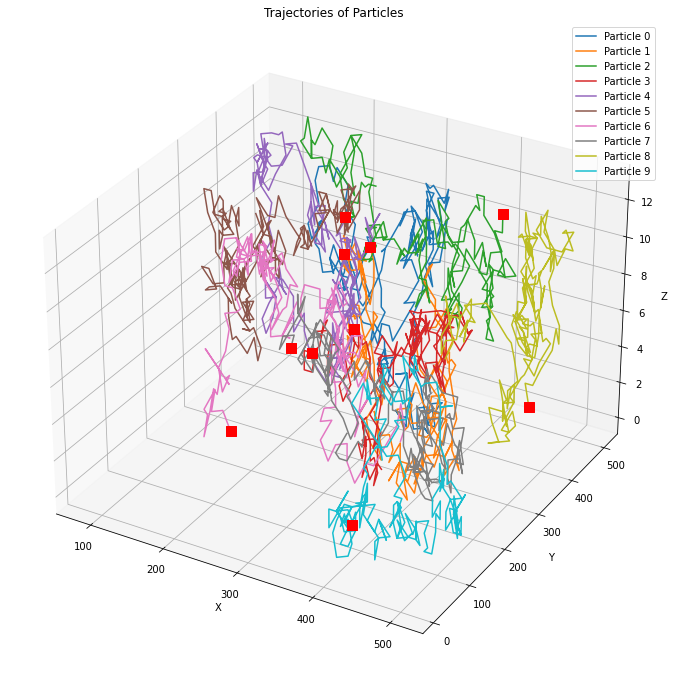

In [34]:
def plot_trajectories(df):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    for particle, group in df.groupby('particle'):
        ax.plot(group['x'], group['y'], group['z'], label=f'Particle {particle}')
        ax.scatter(group['x'].iloc[0], group['y'].iloc[0], group['z'].iloc[0], color='red', marker='s', s=100)  # Square marker at the start
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trajectories of Particles')
    ax.legend()
    plt.show()
    
plot_trajectories(random_walk_df) 


In [35]:
f = random_walk_df.drop('particle', axis=1)


In [36]:
f['xum'] = f['x']  #* 0.21
f['yum'] = f['y']   #* 0.21
f['zum'] = f['z']   #* 0.75

In [37]:
for search_range in [0.5, 1.0, 1.5, 2.0, 2.5,5,10,20,30]:
    linked = tp.link_df(f, search_range, pos_columns=['xum', 'yum', 'zum'],memory=0)
    filtered = tp.filter_stubs(linked, threshold=51)
    print('range: ' ,str(search_range), ' number of tracks: ', len(filtered.particle.unique()))


range:  0.5  number of tracks:  0
range:  1.0  number of tracks:  0
range:  1.5  number of tracks:  0
range:  2.0  number of tracks:  0
range:  2.5  number of tracks:  0
range:  5  number of tracks:  0
range:  10  number of tracks:  0
range:  20  number of tracks:  10
range:  30  number of tracks:  10


In [38]:
linked = tp.link_df(f, 20, pos_columns=['xum', 'yum', 'zum'],memory=1)#
linked

frame           x           y          z         xum         yum  \
0        0  224.794901  409.180122   7.774415  224.794901  409.180122   
0        0  244.607879  369.780900  10.668824  244.607879  369.780900   
0        0  223.276665  439.650927   3.078333  223.276665  439.650927   
0        0  350.505040  223.568131  12.548057  350.505040  223.568131   
0        0  472.803956  420.064684   2.011362  472.803956  420.064684   
..     ...         ...         ...        ...         ...         ...   
199    199  220.561832  506.795010   9.912510  220.561832  506.795010   
199    199  440.505040  213.568131   4.548057  440.505040  213.568131   
199    199  314.794901  419.180122   9.774415  314.794901  419.180122   
199    199  372.803956  390.064684   4.011362  372.803956  390.064684   
199    199  423.008289  108.186274   4.189077  423.008289  108.186274   

           zum  particle  
0     7.774415         0  
0    10.668824         1  
0     3.078333         2  
0    12.548057         3  
0     2.011362         4  
..         ...       ...  
199   9.912510         2  
199   4.548057         9  
199   9.774415         0  
199   4.011362         4  
199   4.189077         6  

[2000 rows x 8 columns]

In [39]:
filtered = tp.filter_stubs(linked, threshold=50)
filtered

frame           x           y          z         xum         yum  \
frame                                                                     
0          0  224.794901  409.180122   7.774415  224.794901  409.180122   
0          0  244.607879  369.780900  10.668824  244.607879  369.780900   
0          0  223.276665  439.650927   3.078333  223.276665  439.650927   
0          0  350.505040  223.568131  12.548057  350.505040  223.568131   
0          0  472.803956  420.064684   2.011362  472.803956  420.064684   
...      ...         ...         ...        ...         ...         ...   
199      199  220.561832  506.795010   9.912510  220.561832  506.795010   
199      199  440.505040  213.568131   4.548057  440.505040  213.568131   
199      199  314.794901  419.180122   9.774415  314.794901  419.180122   
199      199  372.803956  390.064684   4.011362  372.803956  390.064684   
199      199  423.008289  108.186274   4.189077  423.008289  108.186274   

             zum  particle  
frame                       
0       7.774415         0  
0      10.668824         1  
0       3.078333         2  
0      12.548057         3  
0       2.011362         4  
...          ...       ...  
199     9.912510         2  
199     4.548057         9  
199     9.774415         0  
199     4.011362         4  
199     4.189077         6  

[2000 rows x 8 columns]

In [40]:
total_detected_particles = len(filtered['particle'].unique())
total_detected_particles

10

In [31]:
print('Spots:  [Z, Y, X,]')
print(spots[0:3,:]) # [Z, Y, X,]

print('_______')

print('Clusters: [Z, Y, X, size,index]')
print(clusters) # [Z, Y, X, size,index]


Spots:  [Z, Y, X,]
[[  5 175 340]
 [  6 154 269]
 [  6 157 273]]
_______
Clusters: [Z, Y, X, size,index]
[]
